# Cocktail Party Dataset
The original dataset can be found at: [https://tev.fbk.eu/resources/cocktailparty](https://tev.fbk.eu/resources/cocktailparty)

Download the following two files from Google Drive and save them to `datasets/cocktailparty/`:
- [groupings file (grouping.ref)](https://drive.google.com/open?id=0Bzf1l8WmTwu0ZUdMOFRiZ1JyS3M)
- [features file (tracking_hp.log)](https://drive.google.com/open?id=0Bzf1l8WmTwu0ZWxZdVZ0RUFFNm8)

## Create binary classification data

In [1]:
import os
import glob
DATA_PATH = os.path.expanduser('~/btg/data')
CP_PATH = os.path.join(DATA_PATH, 'cocktailparty')
files = list(glob.iglob(os.path.join(CP_PATH, '*')))
files

['/home/ntsoi/btg/data/cocktailparty/tracking_hp.log',
 '/home/ntsoi/btg/data/cocktailparty/cp_binary.csv',
 '/home/ntsoi/btg/data/cocktailparty/grouping.ref']

In [2]:
fnames = [x.split('/')[-1] for x in files]
assert 'tracking_hp.log' in fnames
assert 'grouping.ref' in fnames

In [3]:
import numpy as np
import re

# load the data
def load_group_data_from_text_files(features_path, groups_path):
    """
    Helper function to load group data from text files
    :param features_path: path to file with individual features
    :param groups_path: path to groups
    :return: tuple with features and group data organized as dictionaries, list of people's ids, and num features
    :note: this function filters the feature frames to only return those matching group timestamps
    """
    features_per_frame = np.genfromtxt(os.path.join(CP_PATH, features_path), dtype='str')
    groups_per_frame = np.genfromtxt(os.path.join(CP_PATH, groups_path), dtype='str', delimiter=',')

    # convert group data to dict
    stamps = []
    groups_dict = {}
    for groups in groups_per_frame:
        groups_arr = re.split(" < | > < ", groups)
        s = groups_arr[0]

        stamps.append(s)
        groups_dict[s] = []

        last_index = -1
        for group in groups_arr[1:]:
            last_index += 1
            groups_dict[s].append(re.split(" ", group))

        # remove last > character
        if len(groups_arr[1:]) == 0:
            continue

        groups_dict[s][last_index] = groups_dict[s][last_index][:-1]

    # filter features frames
    features_dict = {}
    features_stamps = list(features_per_frame[:, 0])
    num_features = None
    pid_set = set()

    def check_num_features(num_features, f):
        """Helper function to update the number of features estimated so far and check for consistency"""
        if num_features is None:
            num_features = len(f)
        elif num_features != len(f):
            raise RuntimeError("Inconsistent number of features (got {} but expected {})".
                               format(len(f), num_features))
        return num_features

    for s in stamps:
        # get features data for the given stamp
        frame_idx = features_stamps.index(s)
        people = features_per_frame[frame_idx][1:]
        features = {}

        # parse people list
        pid = None
        f = []
        for i in range(len(people)):
            if people[i][0:2] == "ID":
                if pid is not None:
                    features[pid] = f
                    num_features = check_num_features(num_features, f)
                pid = people[i]
                f = []
            else:
                f.append(float(people[i]))
        if pid is not None:
            features[pid] = f
            num_features = check_num_features(num_features, f)

        # save people's identifiers
        for identifier in features.keys():
            if identifier not in pid_set:
                pid_set.add(identifier)

        # store features for this frame
        features_dict[s] = features

    # convert person ids from set to list
    person_ids = list(pid_set)
    person_ids.sort()

    return features_dict, groups_dict, person_ids, num_features

groups_filename = 'grouping.ref'
features_filename = 'tracking_hp.log'

features_dict, groups_dict, person_ids, num_features = \
    load_group_data_from_text_files(features_filename, groups_filename)

print("Loaded data for {} frames with group annotations.".format(len(groups_dict.keys())))

Loaded data for 320 frames with group annotations.


In [4]:
# create affinity matrices for each annotated frame with groups
def create_affinity_matrices(groups_dict, person_ids):
    """Helper function to create affinity matrices for groups
    :param groups_dict: groups dictionary as output by load_group_data_from_text_files()
    :param person_ids: list of person IDs as output by load_group_data_from_text_files()
    :return dict with affinity matrices (keys are timestamps, values are numpy arrays)
    """
    num_people = len(person_ids)
    affinities = {}

    # process each frame
    for stamp in groups_dict.keys():
        matrix = np.zeros((num_people, num_people))
        groups_list = groups_dict[stamp]

        for group in groups_list:
            for i, sid1 in enumerate(group):
                index1 = person_ids.index(sid1)
                for j, sid2 in enumerate(group[i+1:]):
                    index2 = person_ids.index(sid2)
                    matrix[index1, index2] = 1.0
                    matrix[index2, index1] = 1.0

        affinities[stamp] = matrix

    return affinities

affinities = create_affinity_matrices(groups_dict, person_ids)
print("Created {} affinity matrices.".format(len(affinities.keys())))

stamp = next(iter(affinities.keys()))
print("\nExample affinity matrix for frame {}:\n{}\nGroups:{}".format(stamp, affinities[stamp], groups_dict[stamp]))

Created 320 affinity matrices.

Example affinity matrix for frame 1275403283.267134:
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Groups:[['ID_006', 'ID_001'], ['ID_002', 'ID_003', 'ID_004', 'ID_005']]


In [5]:
# create binary classification samples
def make_sample(stamp, i, id1, j, id2, affinities, features_dict, person_ids):
    """
    Helper function to make the sample for a given stamp and dyad
    :param stamp: frame stamp
    :param i: index for person id 1 in self.person_ids
    :param id1: person id 1
    :param j: index for person id 2 in self.person_ids
    :param id2: person index 2
    :return: tuple with dyad and context tensor, and target
    """
    # get target from affinity matrix
    target = affinities[stamp][i, j]

    # get dyad features
    feat1 = features_dict[stamp][id1]
    feat2 = features_dict[stamp][id2]
    dyad_tensor = np.vstack([feat1, feat2])

    # get context features
    remaining_ids = set(person_ids)
    remaining_ids.remove(id1)
    remaining_ids.remove(id2)
    remaining_feat = []
    for pid in remaining_ids:
        remaining_feat.append(features_dict[stamp][pid])
    context_tensor = np.vstack(remaining_feat)

    return (dyad_tensor, context_tensor), target

def create_examples(groups_dict, person_ids, affinities, features_dict):
    """
    Create <input, target> pairs, where input = (dyad_input, context_input) and target in [0,1]
    """
    # sort the examples based on stamp so that we can easily reate subsets (folds) of the dataset later
    stamps = [(float(x), x) for x in groups_dict.keys()]
    stamps.sort(key=lambda x: x[0])
    
    inputs = []
    targets = []
    stamps_to_input_targets = {}

    # process every frame
    for _, stamp in stamps:

        indices = []

        # process every dyad
        for i, id1 in enumerate(person_ids):
            for j, id2 in enumerate(person_ids[i+1:]):

                (dyad_tensor, context_tensor), target = make_sample(stamp, i, id1, j+(i+1), id2, 
                                                                    affinities, features_dict, person_ids)

                inputs.append((dyad_tensor, context_tensor))
                targets.append(target)

                indices.append((len(inputs) - 1, i, j+(i+1)))

        stamps_to_input_targets[stamp] = indices
        
    return inputs, targets, stamps_to_input_targets, stamps

inputs, targets, stamps_to_input_targets, stamps = \
create_examples(groups_dict, person_ids, affinities, features_dict)

assert len(inputs) == len(affinities.keys())*((6 * 6) - 6)/2, \
"Expected {} examples but got {}".format(((6 * 6) - 6)/2, len(inputs))

print("Created num_frames * (num_people * (num_people - 1) / 2) = {} dyad samples.".format(len(inputs)))

Created num_frames * (num_people * (num_people - 1) / 2) = 4800 dyad samples.


In [6]:
import random

# Randomly swap the order of dyads
def swap_dyad(input_tensors, p = 0.5):
    """
    Helper function to swap the dyad order in the input tensor
    :param input_tensors: input tensors
    :return: transformed tensors
    """
    dyad_input, context_input = input_tensors
    
    if len(dyad_input.shape) != 2:
        raise RuntimeError("Expected the dyad_input in the sample to have 2 dimensions, but got {} (shape={})".
                           format(len(dyad_input.shape), dyad_input.shape))
    
    sampled_value = random.random()
    swap = sampled_value < p
    if swap:
        new_dyad = dyad_input[[1, 0], :]
    else:
        new_dyad = np.copy(dyad_input)
    
    return (new_dyad, np.copy(context_input)), swap

    
swapped_inputs = []  # new inputs
swapped_bool = []    # list to keep track of when indices were swapped
for s, input_tensors in enumerate(inputs):
    new_inputs, swap = swap_dyad(input_tensors)
    swapped_bool.append(swap)
    swapped_inputs.append(new_inputs)
    
print("Swapped dyad order to make the dataset more balanced.")

print("Examples:")
for i in range(2):
    print("\n-Original inputs-\nDyad:\n{}\nContext:\n{}".format(inputs[i][0], inputs[i][1]))
    print("\n-Centered inputs-\nDyad:\n{}\nContext:\n{}".format(swapped_inputs[i][0], swapped_inputs[i][1]))

Swapped dyad order to make the dataset more balanced.
Examples:

-Original inputs-
Dyad:
[[ 3.73  2.24 -0.3 ]
 [ 2.19  4.31  0.53]]
Context:
[[ 2.39  5.07 -1.25]
 [ 3.17  4.76  2.89]
 [ 3.72  2.98 -0.39]
 [ 3.58  3.87  2.26]]

-Centered inputs-
Dyad:
[[ 2.19  4.31  0.53]
 [ 3.73  2.24 -0.3 ]]
Context:
[[ 2.39  5.07 -1.25]
 [ 3.17  4.76  2.89]
 [ 3.72  2.98 -0.39]
 [ 3.58  3.87  2.26]]

-Original inputs-
Dyad:
[[ 3.73  2.24 -0.3 ]
 [ 3.17  4.76  2.89]]
Context:
[[ 2.39  5.07 -1.25]
 [ 3.72  2.98 -0.39]
 [ 3.58  3.87  2.26]
 [ 2.19  4.31  0.53]]

-Centered inputs-
Dyad:
[[ 3.17  4.76  2.89]
 [ 3.73  2.24 -0.3 ]]
Context:
[[ 2.39  5.07 -1.25]
 [ 3.72  2.98 -0.39]
 [ 3.58  3.87  2.26]
 [ 2.19  4.31  0.53]]


In [7]:
# Center the position and orientation data relative to the dyad of interest
def center_sample(input_tensors, x_index = 0, y_index = 1, angle_index = 2):
    """Center a given sample relative to the dyad
    :param sample: sample
    :param x_index: position for the horizontal coordinate in the input tensors
    :param y_index: position for the vertical coordinate in the input tensors
    :param angle_index: position for the angle in the input tensors
    """
    dyad_input, context_input = input_tensors

    if len(dyad_input.shape) != 2:
        raise RuntimeError("Expected the dyad_input in the sample to have 2 dimensions, but got {} (shape={})".
                           format(len(dyad_input.shape), dyad_input.shape))
    if len(context_input.shape) != 2:
        raise RuntimeError("Expected the context_input in the sample to have 2 dimensions, but got {} (shape={})".
                           format(len(context_input.shape), context_input.shape))
    
    def _transform_tensor(input_tensor, center, gamma):
        """
        Helper function to transform the inputs in a sample
        :param input_tensor: 2D input tensor
        :param center: center of the new cooordinate frame (it's between the dyad)
        :param gamma: orientation (in radians) of the x axis of the new coordinate frame
        :return: transformed input_tensor
        """
        new_tensor = np.copy(input_tensor) 
        # translate position (center frame)
        new_tensor[:, x_index] -= np.tile(center[0], new_tensor.shape[0])  
        new_tensor[:, y_index] -= np.tile(center[1], new_tensor.shape[0])
        # rotate position (orient frame)
        c = np.cos(-gamma) 
        s = np.sin(-gamma)  
        new_x = c * new_tensor[:, x_index] - s * new_tensor[:, y_index]
        new_y = s * new_tensor[:, x_index] + c * new_tensor[:, y_index]
        new_tensor[:, x_index] = new_x
        new_tensor[:, y_index] = new_y
        # transform orientation
        new_tensor[:, angle_index] -= np.tile(gamma, input_tensor.shape[0])
        return new_tensor

    center = np.sum(dyad_input[:, [x_index, y_index]], 0) * 0.5  

    dx = dyad_input[0, x_index] - dyad_input[1, x_index]
    dy = dyad_input[0, y_index] - dyad_input[1, y_index]
    gamma = np.arctan2(dy, dx)

    new_dyad = _transform_tensor(dyad_input, center, gamma)
    new_context = _transform_tensor(context_input, center, gamma)

    return new_dyad, new_context

centered_inputs = []
for input_tensors in swapped_inputs:
    centered_inputs.append(center_sample(input_tensors))
    
print("Centered the input tensors.")
print("Example:")
print("\n-Original inputs-\nDyad:\n{}\nContext:\n{}".format(swapped_inputs[0][0], swapped_inputs[0][1]))
print("\n-Centered inputs-\nDyad:\n{}\nContext:\n{}".format(centered_inputs[0][0], centered_inputs[0][1]))

Centered the input tensors.
Example:

-Original inputs-
Dyad:
[[ 2.19  4.31  0.53]
 [ 3.73  2.24 -0.3 ]]
Context:
[[ 2.39  5.07 -1.25]
 [ 3.17  4.76  2.89]
 [ 3.72  2.98 -0.39]
 [ 3.58  3.87  2.26]]

-Centered inputs-
Dyad:
[[ 1.29000969e+00 -1.11022302e-16 -1.68042149e+00]
 [-1.29000969e+00  1.11022302e-16 -2.51042149e+00]]
Context:
[[ 1.7803936  -0.61410391 -3.46042149]
 [ 1.06609664 -1.0548758   0.67957851]
 [-0.69032427 -0.43367891 -2.60042149]
 [ 0.1073054  -0.85259049  0.04957851]]


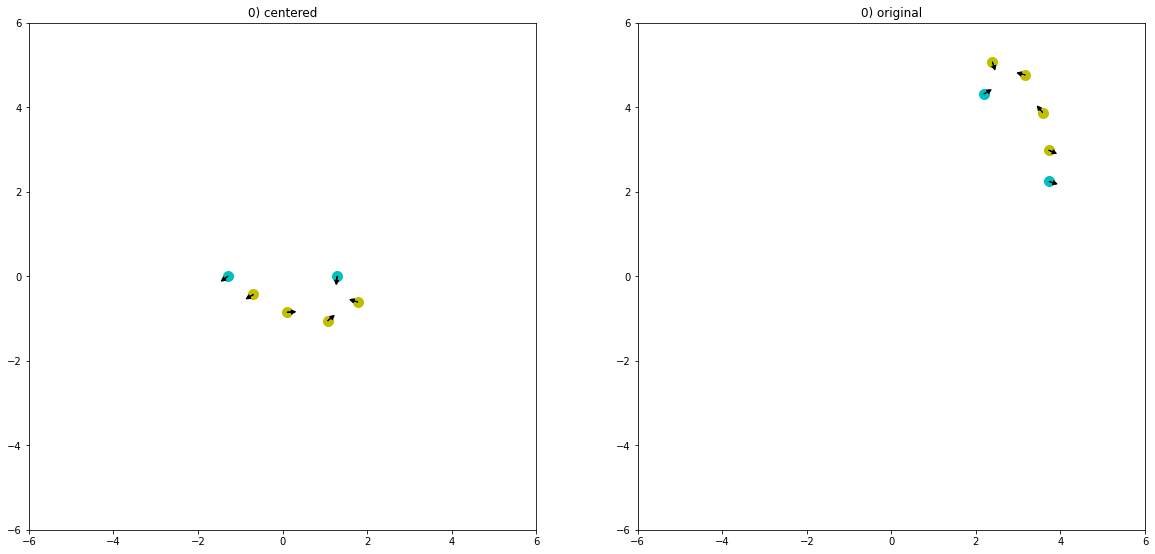

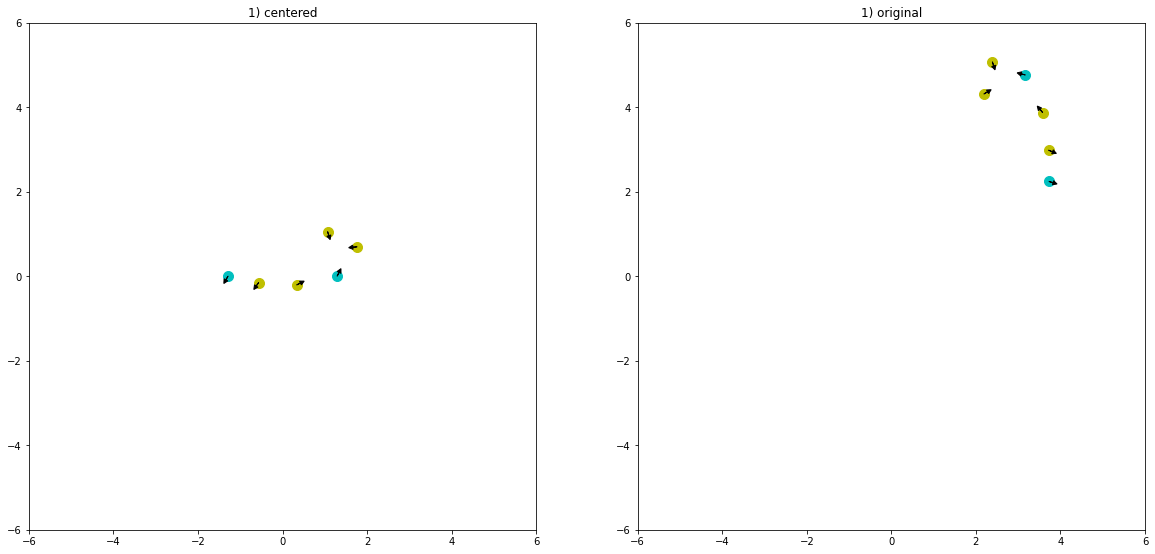

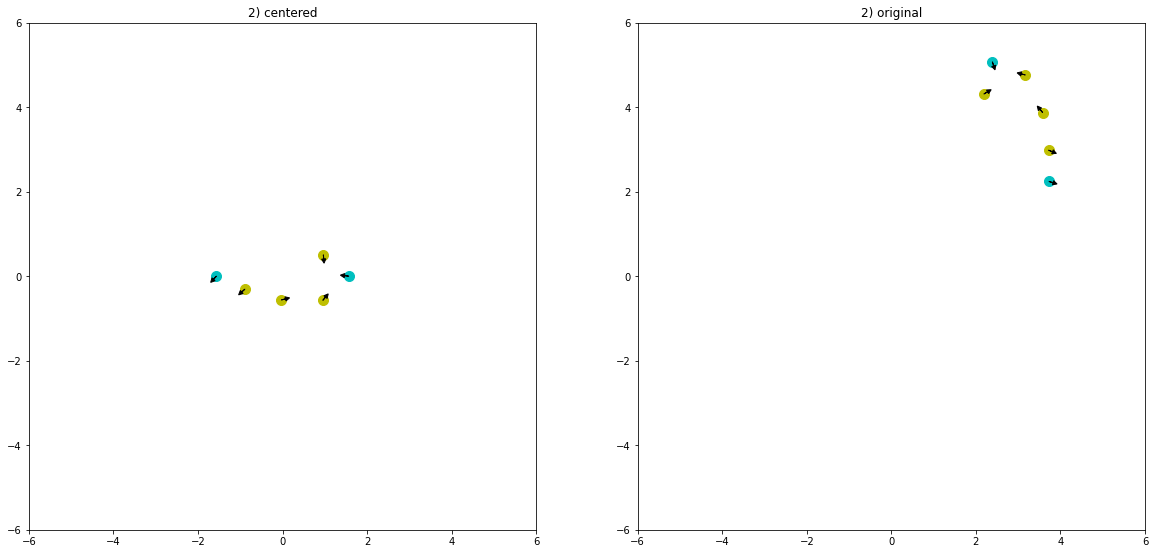

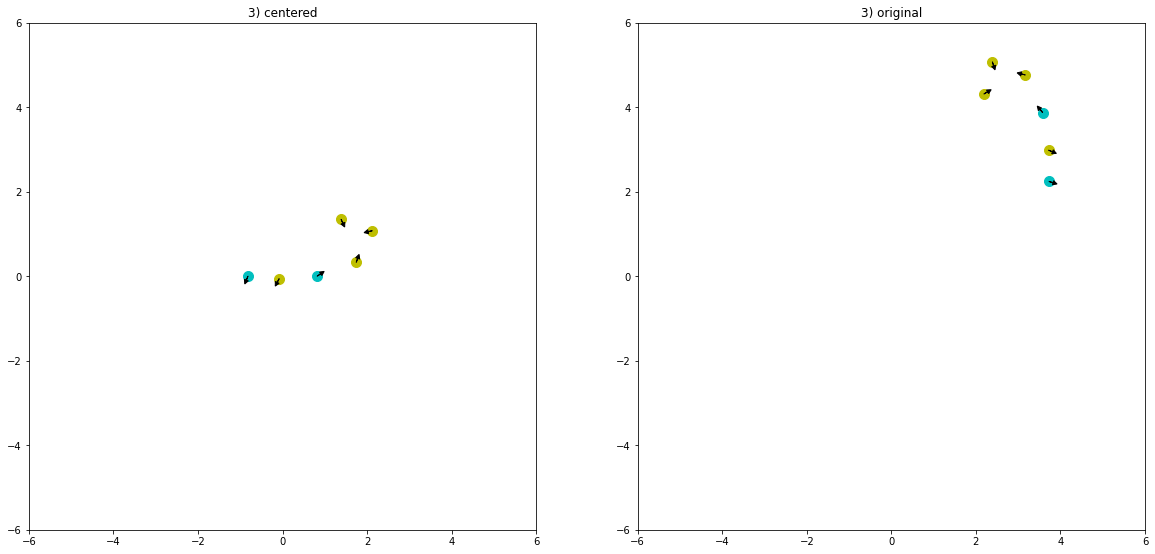

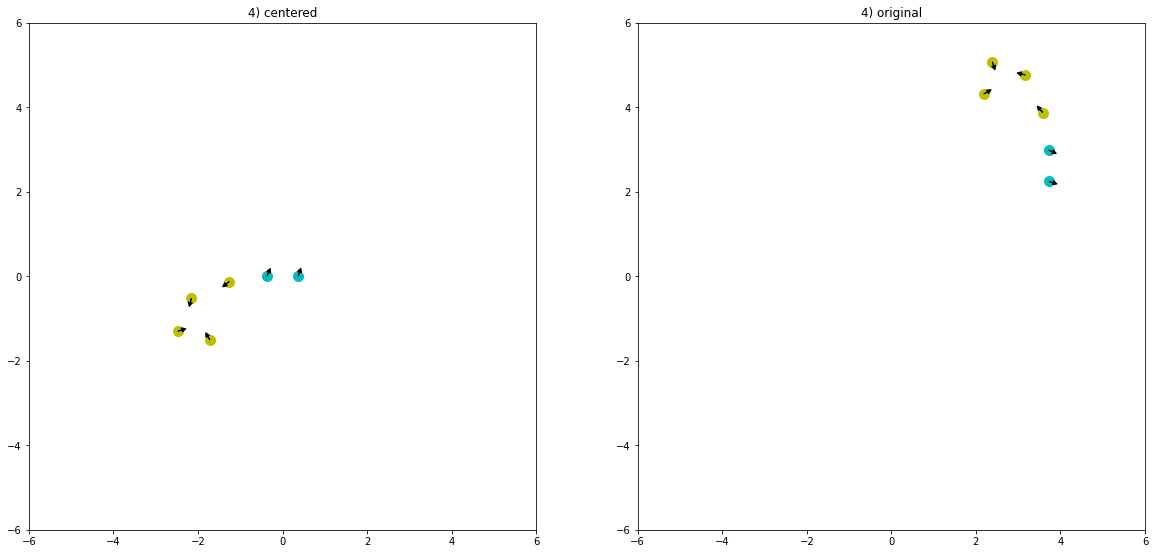

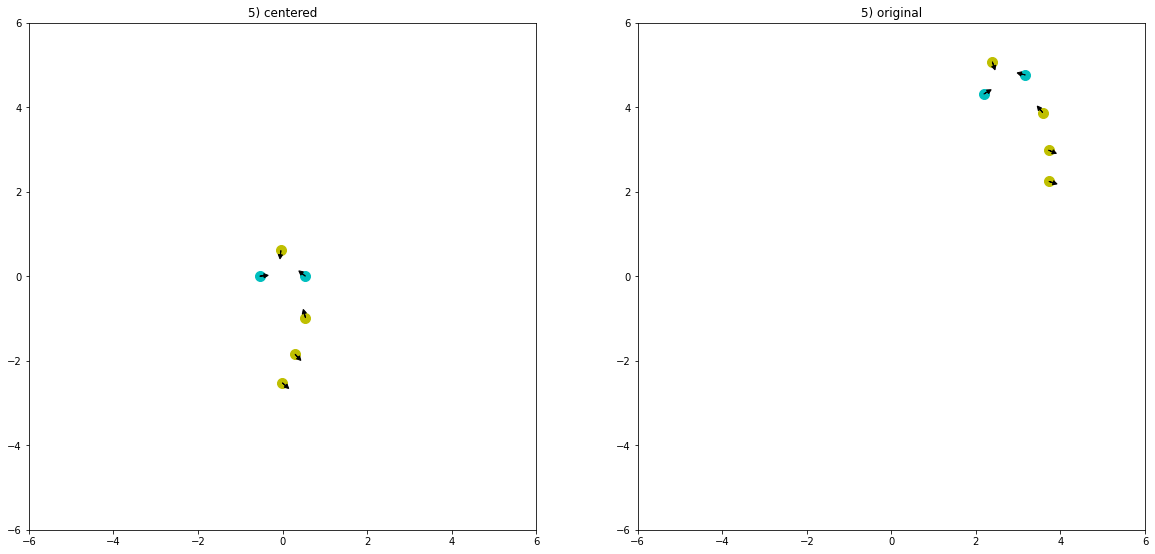

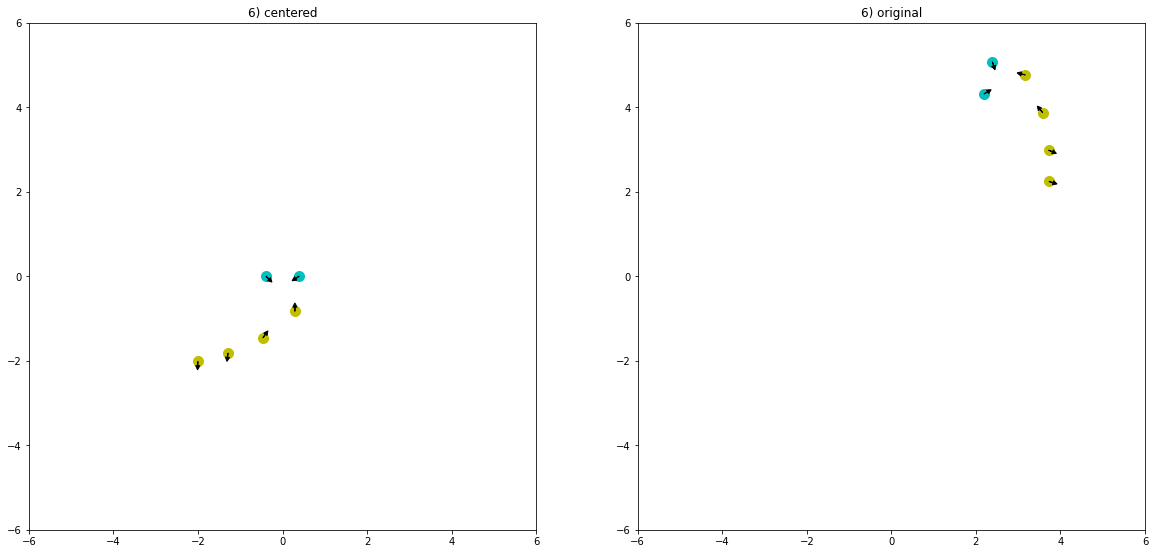

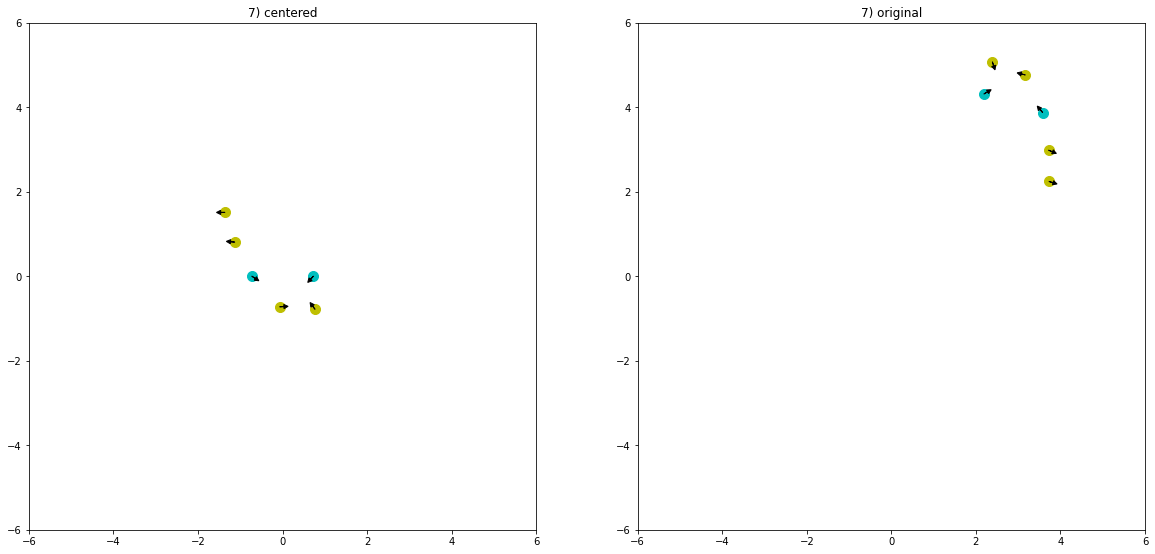

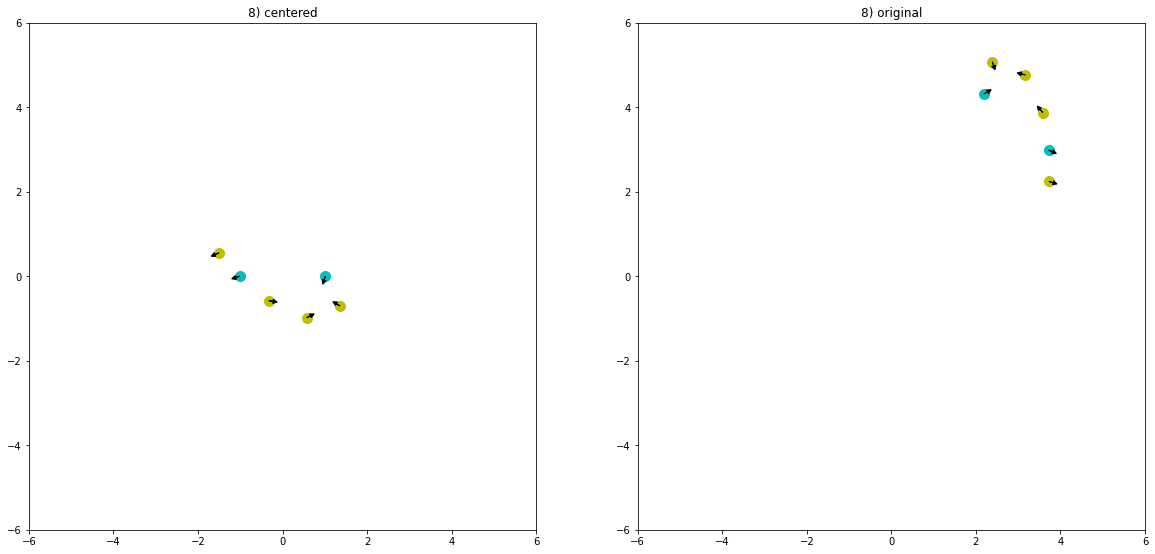

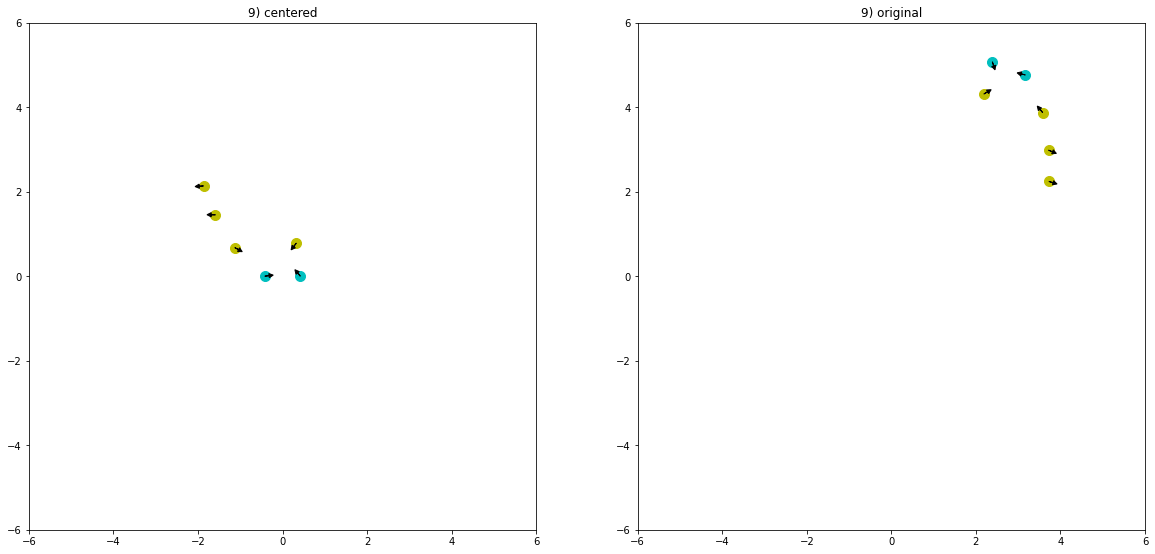

In [8]:
import matplotlib.pyplot as plt

def plot_input_tensors(inputs_dict):
    
    def plot_inputs(input_tensors, x_index=0, y_index=1, angle_index=2):
        """
        Plot affinity dataset sample
        :param sample: tuple with inputs (dyad and context)
        :param x_index: index for the horizontal position
        :param y_index: index for the vertical position
        :param angle_index: index for the orientation being visualized
        :return: plt figure
        """
        dyad, context = input_tensors

        def plot_person(tensor, i, color):
            plt.scatter(tensor[i][x_index], tensor[i][y_index], s=100, color=color)
            arrow_x = 0.1 * np.cos(tensor[i][angle_index])
            arrow_y = 0.1 * np.sin(tensor[i][angle_index])  # draws an arrow for head pose
            plt.arrow(tensor[i][x_index], tensor[i][y_index], arrow_x, arrow_y,
                      head_width=0.1, head_length=0.1, color='black')

        for i in range(dyad.shape[0]):
            plot_person(dyad, i, color='c')

        for i in range(context.shape[0]):
            plot_person(context, i, color='y')
    
    k = list(inputs_dict.keys())
    k.sort()
    f = plt.figure(figsize=(10*len(k), 10))
    for i, name in enumerate(k):
        ax = f.add_subplot(1, len(k), i+1)
        plot_inputs(inputs_dict[name])
        ax.set_aspect('equal', 'box')
        ax.set_title(name)
        ax.set_xlim((-6,6))
        ax.set_ylim((-6,6))

        
for i in range(10):
    plot_input_tensors({'{}) original'.format(i): swapped_inputs[i], 
                        '{}) centered'.format(i): centered_inputs[i]})
    plt.show()

In [9]:
# Convert the angular data to the rectangular representation: cos(theta), sin(theta)
def rectangular_angle(input_tensors, angle_index = 2):
    """Transform a given sample by converting the angle to cos(angle) and sin(angle)
    :param input_tensors: input tensors
    :param angle_index: index for the orientation (angular) value
    :return: transformed sample
    """
    
    dyad_input, context_input = input_tensors

    if len(dyad_input.shape) != 2:
        raise RuntimeError("Expected the dyad_input in the sample to have 2 dimensions, but got {} (shape={})".
                           format(len(dyad_input.shape), dyad_input.shape))
    if len(context_input.shape) != 2:
        raise RuntimeError("Expected the context_input in the sample to have 2 dimensions, but got {} (shape={})".
                           format(len(context_input.shape), context_input.shape))
    if dyad_input.shape[-1] != context_input.shape[-1]:
        raise RuntimeError("Expected the dyad and context tensors to have the same number of features "
                           "(got {} and {})".format(dyad_input.shape[-1], context_input.shape[-1]))

    # compute new number of features, which dimensions we are keeping, and allocate output tensors
    final_dims = dyad_input.shape[-1] + 1

    keep_dims = list(set(list(range(dyad_input.shape[-1]))) - set([angle_index]))

    new_dyad = np.zeros((dyad_input.shape[0], final_dims), dtype=dyad_input.dtype)
    new_context = np.zeros((context_input.shape[0], final_dims), dtype=context_input.dtype)

    # copy same values
    for i, index in enumerate(keep_dims):
        new_dyad[:, i] = dyad_input[:, index]
        new_context[:, i] = context_input[:, index]

    # transform angles
    k = len(keep_dims)
    for i, index in enumerate([angle_index]):
        new_dyad[:, k + i*2] = np.cos(dyad_input[:, index])
        new_dyad[:, k + i*2 + 1] = np.sin(dyad_input[:, index])
        new_context[:, k + i*2] = np.cos(context_input[:, index])
        new_context[:, k + i*2 + 1] = np.sin(context_input[:, index])

    return new_dyad, new_context

rectangular_inputs = []
for input_tensors in centered_inputs:
    rectangular_inputs.append(rectangular_angle(input_tensors))
    
print("Converted angles to the rectangular representation.")
print("Example:")
print("\n-Original inputs-\nDyad:\n{}\nContext:\n{}".format(centered_inputs[0][0], centered_inputs[0][1]))
print("\n-Centered inputs-\nDyad:\n{}\nContext:\n{}".format(rectangular_inputs[0][0], rectangular_inputs[0][1]))

Converted angles to the rectangular representation.
Example:

-Original inputs-
Dyad:
[[ 1.29000969e+00 -1.11022302e-16 -1.68042149e+00]
 [-1.29000969e+00  1.11022302e-16 -2.51042149e+00]]
Context:
[[ 1.7803936  -0.61410391 -3.46042149]
 [ 1.06609664 -1.0548758   0.67957851]
 [-0.69032427 -0.43367891 -2.60042149]
 [ 0.1073054  -0.85259049  0.04957851]]

-Centered inputs-
Dyad:
[[ 1.29000969e+00 -1.11022302e-16 -1.09405718e-01 -9.93997178e-01]
 [-1.29000969e+00  1.11022302e-16 -8.07336967e-01 -5.90090689e-01]]
Context:
[[ 1.7803936  -0.61410391 -0.94960318  0.31345463]
 [ 1.06609664 -1.0548758   0.77783768  0.62846523]
 [-0.69032427 -0.43367891 -0.85710595 -0.51514016]
 [ 0.1073054  -0.85259049  0.99877124  0.04955821]]


In [10]:
# Write examples to a csv file
out_file = os.path.join(CP_PATH, 'cp_binary.csv')

with open(out_file, 'w') as fid:
    fid.write("stamp,sample_no,swapped,person1_index,person2_index,person1_id,person2_id,"
              "dyad1_x,dyad1_y,dyad1_cosa,dyad1_sina,"
              "dyad2_x,dyad2_y,dyad2_cosa,dyad2_sina,"
              "context1_x,context1_y,context1_cosa,context1_sina,"
              "context2_x,context2_y,context2_cosa,context2_sina,"
              "context3_x,context3_y,context3_cosa,context3_sina,"
              "context4_x,context4_y,context4_cosa,context4_sina,"
              "target\n")
    
    stamps = [(float(x), x) for x in groups_dict.keys()]
    stamps.sort(key=lambda x: x[0])
    
    for _,s in stamps:
        
        print("\rWriting data for frame {}".format(s), end="")
        indices = stamps_to_input_targets[s]
        
        for sample_index, i, j in indices:
            pid1 = person_ids[i]
            pid2 = person_ids[j]

            dyad_tensor, context_tensor = rectangular_inputs[sample_index]
            target_value = targets[sample_index]
            swapped = swapped_bool[sample_index]
            
            line_str = str()
            line_str = "{},{},{},".format(s,sample_index,swapped)
            
            if swapped:
                line_str += "{},{},{},{},".format(j,i,pid2,pid1)
            else:
                line_str += "{},{},{},{},".format(i,j,pid1,pid2)
                
            for i in range(dyad_tensor.shape[0]):
                line_str += ",".join(["%.4f" % x for x in dyad_tensor[i,:].tolist()])
                line_str += ","
                
            for i in range(context_tensor.shape[0]):
                line_str += ",".join(["%.4f" % x for x in context_tensor[i,:].tolist()])
                line_str += ","
                
            line_str += "%d\n" % target_value

            fid.write(line_str)
        
print("\nDone.")

Writing data for frame 1275404938.331096
Done.
